### Info
Plotting comparisons

In [1]:
import numpy as np
import pandas as pd

### Load data into a DataFrame

In [2]:
min_ind = 1
max_ind = 2

model_names = ('hls','qkeras','qonnx_init','qonnx_mod')
pred_all = []   # will be a list of arrays from each model

for model_name in model_names:
    pred_single = np.array([])
    for file_index in range(min_ind, max_ind+1):
        data = np.load('./pred_SMS_Higgsino/preds_'+model_name+str(file_index)+'.npy')
        pred_single = np.append(pred_single,data)
        #print(pred_single.shape)
    pred_all.append(pred_single)

pred_all = np.array(pred_all).T

In [3]:
pred_all.shape

(4096, 4)

In [4]:
df = pd.DataFrame(pred_all, columns=model_names)
df

,hls,qkeras,qonnx_init,qonnx_mod
0,130.500,129.250,129.250,129.375
1,2048.250,2043.125,2043.125,2040.000
2,396.375,394.750,394.750,395.500
3,249.000,247.375,247.375,246.500
4,494.250,492.375,492.375,491.000
...,...,...,...,...
4091,306.500,305.250,305.250,306.000
4092,1502.375,1498.625,1498.625,1496.500
4093,179.500,178.000,178.000,177.250
4094,3036.250,3030.500,3030.500,3032.750


### Compare predictions

In [5]:
df['qxinit_qkeras'] = np.abs(df['qonnx_init'] - df['qkeras'])
df['qxinit_qkeras'].value_counts()

qxinit_qkeras
0.0    4096
Name: count, dtype: int64

modified vs unmodified qonnx with respect to hls

In [6]:
df['qxinit_hls'] = np.abs(df['qonnx_init'] - df['hls'])
df['qxmod_hls'] = np.abs(df['qonnx_mod'] - df['hls'])

print(df['qxinit_hls'].value_counts())
print(df['qxmod_hls'].value_counts())

qxinit_hls
2.125    229
2.375    212
2.000    211
1.750    209
2.625    205
        ... 
7.875      2
7.250      1
8.750      1
8.125      1
7.625      1
Name: count, Length: 64, dtype: int64
qxmod_hls
1.750     222
1.250     218
1.500     205
2.000     182
2.500     163
         ... 
8.375       1
10.625      1
11.500      1
11.250      1
9.000       1
Name: count, Length: 84, dtype: int64


### Create histograms

In [7]:
import matplotlib.pyplot as plt

In [8]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl

,2.125,2.375,2.000,1.750,2.625,2.250,1.875,2.500,2.750,1.625,...,10.250,9.125,13.125,10.375,10.500,8.375,10.625,11.500,11.250,9.000
count,229.0,212.0,211.0,209.0,205.0,204.0,195.0,188.0,180.0,167.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,108.0,114.0,182.0,222.0,99.0,144.0,117.0,163.0,146.0,128.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl = dfpl.transpose()
dfpl.columns = ['init','mod']
dfpl = dfpl.fillna(0)
dfpl /= dfpl['init'].sum()  # percentage
dfpl *= 100
dfpl = dfpl.sort_index()
dfpl

,init,mod
0.000,0.073242,0.048828
0.125,0.097656,0.097656
0.250,0.048828,0.097656
0.375,0.073242,0.219727
0.500,0.073242,0.659180
...,...,...
10.500,0.000000,0.024414
10.625,0.000000,0.024414
11.250,0.000000,0.024414
11.500,0.000000,0.024414


In [50]:
def categ(x):
    if x==0.0 : return '0.0'
    if x < 1. : return '0 - 1'
    if x < 5. : return '1 - 5'
    if x < 10. : return '5 - 10'
    if x < 15. : return '10 - 15'
    return 'more'

In [51]:
# Categorize differences (deviations from hls preds)
dfpl['cat'] = dfpl.index.map(categ)

catdf = dfpl.groupby('cat').sum()
catdf

,init,mod
cat,,
0 - 1,1.757812,5.322266
0.0,0.073242,0.048828
1 - 5,94.506836,83.837891
10 - 15,0.000000,0.268555
5 - 10,3.662109,10.522461


In [52]:
catdf = catdf.reindex(['0.0','0 - 1','1 - 5','5 - 10','10 - 15'])
catdf

,init,mod
cat,,
0.0,0.073242,0.048828
0 - 1,1.757812,5.322266
1 - 5,94.506836,83.837891
5 - 10,3.662109,10.522461
10 - 15,0.000000,0.268555


Text(0.5, 1.0, 'Signal (SMS-Higgsino)')

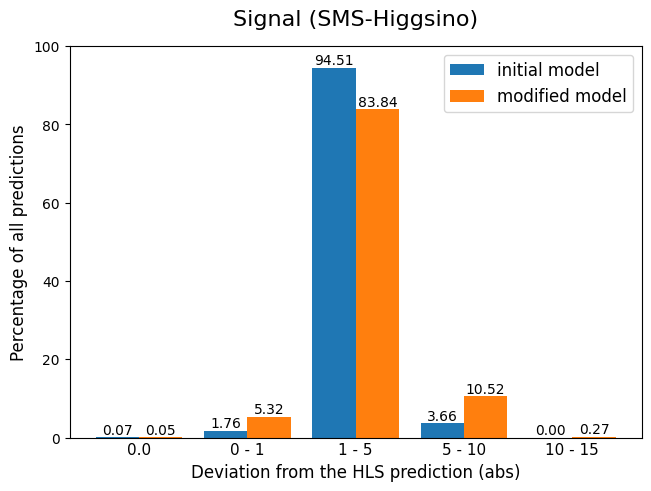

In [68]:
fig, ax = plt.subplots(layout='constrained')
width = 0.4
xticks = np.arange(catdf.shape[0])

labels = ["initial model","modified model"]

for i in range(len(catdf.keys())):
    b = ax.bar(xticks+(-1+i)*width, catdf.values[:,i], width, label=labels[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend(fontsize = 12)
ax.set_xticks(xticks)
ax.set_xticklabels(catdf.index.to_list(),fontdict={'size': 11})
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel("Deviation from the HLS prediction (abs)",{'size': 12})
ax.set_ylim(0,100)
ax.set_ylabel("Percentage of all predictions",{'size': 12})
ax.set_title("Signal (SMS-Higgsino)",fontdict={'size': 16},pad=15)


In [69]:
fig.savefig('Higgsino.pdf')